# Analysis for the ReproPhylo menuscript

This notebook containts the analysis conducted for the ReproPhylo manuscript. [The repository containig it](https://github.com/HullUni-bioinformatics/Szitenberg_et_all_15-ReproPhylo), as well as related files, is at [https://github.com/HullUni-bioinformatics](https://github.com/HullUni-bioinformatics). The ReproPhylo pipeline is needed to run it is provided as a [Docker image](https://registry.hub.docker.com/u/szitenberg/reprophylo/). The manual and development version is in our Git page [GitHub page](http://hulluni-bioinformatics.github.io/ReproPhylo/).



# Table of content
1   [The full unannotates script](#1-The-full,-unannotated-script:)  
2   [The same script, with annotations](#2-The-same-script,-with-annotations)    
&nbsp;&nbsp;&nbsp;2.1   [Turn a nexus file with PAUP style charset lines into a ReproPhylo Project instance](#2.1-Turn-a-nexus-file-with-PAUP-style-charset-lines-into-a-ReproPhylo-Project-instance)    
&nbsp;&nbsp;&nbsp;2.2   [Read a supplementary table with pandas](#2.2-Read-a-supplementary-table-with-pandas)  
&nbsp;&nbsp;&nbsp;2.3   [Manually assign species to clades](#2.3-Manually-assign-species-to-clades)    
&nbsp;&nbsp;&nbsp;2.4   [Export all the records to a text file](#2.4-Export-all-the-records-to-a-text-file)   
&nbsp;&nbsp;&nbsp;2.5   [Making sure all-gap possitions are removed from the alignments](#2.5-Making-sure-all-gap-positions-are-removed-from-the-read-alignments)    
&nbsp;&nbsp;&nbsp;2.6   [Preparing supermatrices from 200 loci long sliding windows along the entrophy gradient](#2.6-Preparing-supermatrices-from-200-loci-long-sliding-windows-along-the-entropy-gradient)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6.1   [Calculating the statistics](#2.6.1-Calculating-the-statistics)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6.2   [Sort the loci according to statistics values](#2.6.2-Sort-the-alignmnets-according-to-statistics-values)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6.3   [Figure 2A](#2.6.3-Figure-2-A)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.6.4   [Figure S1, Plot a box plot for each parameter and locus](b#2.6.4-Plot-a-box-plot-for-each-parameter-for-each-locus)  
&nbsp;&nbsp;&nbsp;2.7   [Prepare the Concatenation objects](#2.7-Prepare-the-Concatenation-objects)  
&nbsp;&nbsp;&nbsp;2.8   [Reconstruct the trees](#2.8-Reconstruct-the-trees)  
&nbsp;&nbsp;&nbsp;2.9   [Verify the git commit](#2.9-Verify-git-commit)  
&nbsp;&nbsp;&nbsp;2.10  [Plot the trees, Figure 2A 1-6](#2.10-Plot-the-trees---Figure-2A-1-6)  
&nbsp;&nbsp;&nbsp;2.11  [Robinson Foulds like metrics](#2.11-Robinson-foulds-like-metrics)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.11.1   [Figure 2B - Topological](#2.11.1-Figure-2B:-Topological)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.11.2   [Figure 2C - Branch length](#2.11.2-Figure-2-C:-Branch-length)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.11.3   [Figure 2D - Proportional](#2.11.3-Figure-2-D:-proportional)  
&nbsp;&nbsp;&nbsp;2.12  [Prepare zip folder](#2.12-Prepare-zip-folder)  

# 1 The full, unannotated script:
The cell bellow contains the full analysis. Default values are not shown.  
An annotated version follows. Default values are explicitly indicated there.

In [ ]:
from reprophylo import *


# Read Kawahara_Breinholt_2014 loci and start a Project 
nexus_filename = 'data/Kawahara_Breinholt_2014/'+\
                 'Kawahara_Breinholt_2014_26taxa_465loci_Degen_nt12.nex'
    
pj = pj_from_nexus_w_charset(nexus_filename, 'data', 'dna', 'CDS', project = True,
                             pickle = 'szitenberg_et_al_15_reprophylo',git = True)     

# manually read metadata with pandas from 
# Kawahara_Breinholt_2014 supplementary file
supp3 = 'data/Kawahara_Breinholt_2014/'+\
        'rspb20140970supp3.csv'
    
metadata = pd.read_table(supp3, skiprows=2)

for r in pj.records:
    source = r.features[0]
    original_id = source.qualifiers['original_id'][0]
    record_metadata = metadata.loc[metadata['Sample ID'] == original_id]
    record_metadata = record_metadata.to_dict()for key in record_metadata:                                          # This will add each value in the table
        source.qualifiers[key] = [record_metadata[key].items()[0][1]] 
    source.qualifiers['organism'] = source.qualifiers['Taxa'] 
    
# Manually assign clades to taxa:
clades =       {'Papilio glaucus': 'butterfilies',
                'Macrosoma sp.*': 'butterfilies',
                'Megathymus yuccae*': 'butterfilies',
                'Semomesia campanea': 'butterfilies',
                'Danaus plexippus*': 'butterfilies',
                'Phyllocnistis citrella*': 'I',
                'Plutella xylostella*': 'I',
                'Grapholita dimorpha*': 'I',
                'Lantanophaga pusillidactyla*': 'I',
                'Urodus parvula*': 'I',
                'Morpheis mathani*': 'I',
                'Megalopyge tharops*': 'I',
                'Dalcera abrasa*': 'I',
                'Thubana sp.*': 'III',
                'Pterodecta felderi*': 'III',
                'Zeuzerodes maculata*': 'III',
                'Lacosoma ludolpha*': 'IV',
                'Lyssa zampa*': 'IV',
                'Nothus lunus*': 'IV',
                'Nemoria lixaria*': 'IV',
                'Anigraea sp.': 'IV',
                'Bombyx mori*': 'IV',
                'Manduca sexta*': 'IV',
                'Artace sp.*': 'IV',
                'Myelobia sp.*': 'IV',
                'Actias luna*': 'IV'}

pj.add_qualifier_from_source('Taxa')

for taxon in clades:               
    pj.if_this_then_that(taxon, 'Taxa', clades[taxon], 'Clade')
    
# Remove all gap positions
trimal = TrimalConf(pj, method_name='no_trim', trimal_commands={'noallgaps': True}) 
pj.trim([trimal])

# Calculate loci statistics
# (entropy, conservation, gap score, GC content and sequence lengths)
stats = LociStats(pj)

# Sort the loci according to entropy
stats.sort(parameter = 'entropy', reverse = True)

# Plot the loci statistics as boxplots
stats.plot('plots.png', figsize=(15,23),  params='all',
           lable_fsize=20, xtick_fsize=2, ytick_fsize=1,
           boxcolor='salmon',
           whiskercolor='gray',
           capcolor='black',
           mediancolor='white',
           medianline_w=3)

# Make concatenations of 200 loci sliding window of entropy
concatenations = stats.slide_loci('source_original_id',
                                  parameter='entropy',
                                  start=0,length=200,step=50)  

# Add the concatenation objects to the project
for concat in concatenations:
    pj.add_concatenation(concat)
    
# Create the supermatrices
pj.make_concatenation_alignments()

# And collect their names
aln_names = [c.name for c in pj.concatenations]

# Build the trees
raxml = RaxmlConf(pj, alns=aln_names, threads=6)

# reconstruct the trees
pj.tree([raxml])

# Remove stars from species names  
from itertools import chain

for f in chain(*[r.features for r in pj.records]):
    if 'Taxa' in f.qualifiers:
        f.qualifiers['Taxa'][0] = f.qualifiers['Taxa'][0].replace('*','')
        
pj.propagate_metadata()


# Plot the trees
pics = {'Bombycoidea': 'silhouettes/Bombycoidea.png',
        'Calliduloidea': 'silhouettes/Calliduloidea.png',
        'Cossoidea': 'silhouettes/Cossoidea.png',
        'Gelechioidea': 'silhouettes/Gelechioidea.png',
        'Geometroidea': 'silhouettes/Geometroidea.png',
        'Hepialoidea': 'silhouettes/Hepialoidea.png',
        'Papilionoidea': 'silhouettes/Papilionoidea.png',
        'Mimallonoidea': 'silhouettes/Mimallonoidea.png',
        'Zygaenoidea': 'silhouettes/Zygaenoidea.png',
        'Lasiocampoidea': 'silhouettes/Lasiocampoidea.png',
        'Thyridoidea': 'silhouettes/Thyridoidea.png',
        'Pterophoroidea': 'silhouettes/Pterophoroidea.png',
        'Pyraloidea': 'silhouettes/Pyraloidea.png',
        'Noctuoidea': 'silhouettes/Noctuoidea.png',
        'Gracillarioidea': 'silhouettes/Gracillarioidea.png',
        'Yponomeutoidea': 'silhouettes/Yponomeutoidea.png',
        'Urodoidea': 'silhouettes/Urodoidea.png',
        'Tortricoidea': 'silhouettes/Tortricoidea.png'
        
       }

colors = {'Bombycoidea': 'DodgerBlue',
          'Calliduloidea': 'DodgerBlue',
          'Cossoidea': 'DodgerBlue',
          'Gelechioidea': 'DodgerBlue',
          'Geometroidea': 'DodgerBlue',
          'Hepialoidea': 'DodgerBlue',
          'Papilionoidea': 'SaddleBrown',
          'Mimallonoidea': 'DodgerBlue',
          'Zygaenoidea': 'DodgerBlue',
          'Lasiocampoidea': 'DodgerBlue',
          'Thyridoidea': 'DodgerBlue',
          'Pterophoroidea': 'DodgerBlue',
          'Pyraloidea': 'DodgerBlue',
          'Noctuoidea': 'DodgerBlue',
         'Gracillarioidea': 'DodgerBlue',
         'Yponomeutoidea': 'DodgerBlue',
         'Urodoidea': 'DodgerBlue',
         'Tortricoidea': 'DodgerBlue'}
            
bg =  {'butterfilies': 'LightSkyBlue',
       'I': 'PowderBlue',
       'III': 'LightGrey',
       'IV': 'Beige'
      }


supports = { 'DarkBlue' : [100,99],
             'DimGray': [99,80]}
dir_name = "butterfly_figs"

html_name = "%s/figures.html"%dir_name

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

pj.clear_tree_annotations()  

pj.annotate(dir_name, 'mid','mid', ['Taxa'], 
            leaf_node_color_meta='source_Superfamily',
            leaf_label_colors=colors, ftype='Arial Black',
            fsize=40, node_support_dict=supports,
            support_bullet_size=15, pic_meta='source_Superfamily', 
            pic_paths=pics, pic_w=85, pic_h=65, node_bg_meta='Clade',     
            node_bg_color=bg, branch_width=6, branch_color='RoyalBlue',
            scale=2500, html=html_name)

# Calculate pairwise tree distances
if not os.path.exists('rf_figs'):
    os.mkdir('rf_figs')
    
# topological
figfile1, legend = calc_rf(pj, 'rf_figs', rf_type='topology', unrooted_trees=True, trees=trees)
# branch-length
figfile2, legend = calc_rf(pj, 'rf_figs', rf_type='branch-length', unrooted_trees=True, trees=trees)
# topological
figfile3,legend = calc_rf(pj, 'rf_figs', rf_type='proportional', unrooted_trees=True, trees=trees)

# Write a zip file
publish(pj, 'report', 'butterfly_figs/',
        compare_trees=['topology','branch-length','proportional'],
        trees_to_compare=trees)

# 2 The same script, with annotations

In [1]:
from reprophylo import *

## 2.1 Turn a nexus file with PAUP style charset lines into a ReproPhylo Project instance
Any file format can be read, (see [manual](http://goo.gl/yW6J1J)).  
If GenBank or EMBL formats are read, the metadata is stored and is usable throughout. See example in use case 1 in the [manual](http://goo.gl/yW6J1J).

In [2]:
nexus_filename = 'data/Kawahara_Breinholt_2014/'+\
                 'Kawahara_Breinholt_2014_26taxa_465loci_Degen_nt12.nex'

pj = pj_from_nexus_w_charset(nexus_filename,
                             
                             'data',             # path to write intermediate fasta file    
                             
                             'dna',              # Character type ('dna' or 'prot')
                             
                             'CDS',              # Feature type (Any)
                             
                             project = True,     # Will return a Project instance instead of a list
                                                 # of fasta files per partition 
                                                 # if project will save it to this file:
                             pickle = 'szitenberg_et_al_15_reprophylo',
                             
                             git = True)         # Will start and manage repository

/home/amir/Dropbox/python_modules/rpgit.py:74: UserWarning: Thanks to Stack-Overflow users Shane Geiger and Billy Jin for the git wrappers code
  warnings.warn('Thanks to Stack-Overflow users Shane Geiger and Billy Jin for the git wrappers code')
/home/amir/Dropbox/python_modules/rpgit.py:90: UserWarning: A git repository was created in /home/amir/Dropbox/Szitenberg_et_al_2015_ReproPhylo.
  warnings.warn('A git repository was created in %s.'%repoDir)
/home/amir/Dropbox/python_modules/reprophylo.py:255: UserWarning: The new repository is called szitenberg_et_al_15_reprophylo.
  warnings.warn('The new repository is called %s.'%open(cwd + '/.git/description', 'r').read().rstrip())
DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened


1/465 reading EOG69CQC1_1
2/465 reading EOG6M65NR_1
3/465 reading EOG69KFV8_1
4/465 reading EOG6SN1SH_1
5/465 reading EOG654933_1
6/465 reading EOG66147B_1
7/465 reading EOG6PRSVJ_1
8/465 reading EOG6PRSVH_1
9/465 reading EOG680J15_1
10/465 reading EOG6S7JTK_1
11/465 reading EOG60ZR1Z_1
12/465 reading EOG6DBTJG_1
13/465 reading EOG6FXRCN_1
14/465 reading EOG69ZXTF_1
15/465 reading EOG60P4BD_1
16/465 reading EOG6BCDR6_1
17/465 reading EOG64QT4T_1
18/465 reading EOG6NCMGZ_1
19/465 reading EOG66147D_1
20/465 reading EOG67SSJD_1
21/465 reading EOG6K3M19_1
22/465 reading EOG670TN2_1
23/465 reading EOG60P4BJ_1
24/465 reading EOG6DBTK0_1
25/465 reading EOG647FZH_1
26/465 reading EOG6D5327_1
27/465 reading EOG63TZZV_1
28/465 reading EOG6HDSZD_1
29/465 reading EOG64MXX7_1
30/465 reading EOG68WC5N_1
31/465 reading EOG6GTKHJ_1
32/465 reading EOG68SGXD_1
33/465 reading EOG6G7C30_1
34/465 reading EOG6K6G7Z_1
35/465 reading EOG6SXNH7_1
36/465 reading EOG65X80D_1
37/465 reading EOG6NVZQC_1
38/465 rea

/home/amir/Dropbox/python_modules/reprophylo.py:1216: UserWarning: To get translations, add a feature manually
  warnings.warn("To get translations, add a feature manually")


In [6]:
pickle_pj(pj, 'szitenberg_et_al_15_reprophylo')

'szitenberg_et_al_15_reprophylo'

If the keyword `project` is False (default), the function returns a list of fasta file names and a list of Loci objects.  
This is usefull when the loci are not all the same character type or feature type.  
 
If `project` == False, the usage is:

<pre>
filenames, loci_list = make_fasta_files_from_nexus(nexus_filename,
                                                   'data', 'dna', 'CDS')
pj = Project(loci_list)
                                
for f in filenames:
    locus_name = f.split('/')[-1].split('.')[0]
    pj.read_alignment(f, 'dna','CDS',locus_name)
    
</pre>
                                            
This takes a while (for both project=True and False) because a few things are happening at the background. 
It is worth while for downstream steps
                                                


#### Tip:
Next time you run, start here by unpickling the file:  
<pre>
pj = unpickle_pj('szitenberg_et_al_15_reprophylo')
</pre>

This is much much faster than reading the data. Git will pick up with the same repository.

In [2]:
#pj = unpickle_pj('szitenberg_et_al_15_reprophylo')

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened
/home/amir/Dropbox/python_modules/reprophylo.py:240: UserWarning: Git repository exists for this Project
  warnings.warn('Git repository exists for this Project')


## 2.2 Read a supplementary table with pandas

In [11]:
import pandas as pd


# This reads a supplementary table
# form Kawahara and Breinholt 2014
supp3 = 'data/Kawahara_Breinholt_2014/'+\
        'rspb20140970supp3.csv'
    
metadata = pd.read_table(supp3, skiprows=2)

# This places the info from the table
# in the metadta of the sequence records:

# Iterate all the records (each sequence in each locus)
# and update their metadata based on the supplementary
# table

for r in pj.records:
    source = r.features[0]                                               # This is a Biopython (GenBank)
                                                                         # source feature. Since we read a 
                                                                         # Nexus file, it was generated
                                                                         # by ReproPhylo rather than read.
                                                                         # If a GenBank file is read, the source
                                                                         # and other features are read as well.
                
    original_id = source.qualifiers['original_id'][0]                    # This is the nexus sequence header.
                                                                         # To allow abstraction, the actual
                                                                         # records id is generated by the system
                                                                         # when formats other than GenBank or EMBL
                                                                         # are read
                    
    record_metadata = metadata.loc[metadata['Sample ID'] == original_id] # The 'original_id' is the 'Sample ID'
                                                                         #  in the supplementary table.
                                                                         # This will get the table line for 
                                                                         # the current 'original_id'.
                
    record_metadata = record_metadata.to_dict()                          # This will turn the line into a dictionery 
                                                                         # with column names as keys.
                                                                         # A dictionary is the python equivalent
                                                                         # for the perl array.
    
    for key in record_metadata:                                          # This will add each value in the table
        source.qualifiers[key] = [record_metadata[key].items()[0][1]]    # line to the Biopython feature qualifiers
                                                                         # in the source feature
          
        
    source.qualifiers['organism'] = source.qualifiers['Taxa']            # the 'Taxa' column in the 
                                                                         # supplementary contains
                                                                         # the 'organism' sensu GenBank
        


        
pickle_pj(pj, 'szitenberg_et_al_15_reprophylo')

/usr/local/lib/python2.7/dist-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


'szitenberg_et_al_15_reprophylo'

## 2.3 Manually assign species to clades

In [12]:
clades =       {'Papilio glaucus': 'butterfilies',    # This is a manual assignment of the 'organism'
                'Macrosoma sp.*': 'butterfilies',     # values to lepidopteran clades sensu
                'Megathymus yuccae*': 'butterfilies', # Kawahara and Breinholt 2014.
                'Semomesia campanea': 'butterfilies',
                'Danaus plexippus*': 'butterfilies',
                'Phyllocnistis citrella*': 'I',
                'Plutella xylostella*': 'I',
                'Grapholita dimorpha*': 'I',
                'Lantanophaga pusillidactyla*': 'I',
                'Urodus parvula*': 'I',
                'Morpheis mathani*': 'I',
                'Megalopyge tharops*': 'I',
                'Dalcera abrasa*': 'I',
                'Thubana sp.*': 'III',
                'Pterodecta felderi*': 'III',
                'Zeuzerodes maculata*': 'III',
                'Lacosoma ludolpha*': 'IV',
                'Lyssa zampa*': 'IV',
                'Nothus lunus*': 'IV',
                'Nemoria lixaria*': 'IV',
                'Anigraea sp.': 'IV',
                'Bombyx mori*': 'IV',
                'Manduca sexta*': 'IV',
                'Artace sp.*': 'IV',
                'Myelobia sp.*': 'IV',
                'Actias luna*': 'IV'}

pj.add_qualifier_from_source('Taxa')  # This copies the 'Taxa' qualifier from the source
                                      # feature to all the other features in the record
                                      # (Biopython SeqFeature. See detailed explanation
                                      # in the ReproPhylo manual). It is not necessary,
                                      # but good practice, because we might want to edit
                                      # it for non-source features and keep the original
                                      # as backup in the source feature.

for taxon in clades:                                            # This will assign a 'Clade' qualifier to each 
    pj.if_this_then_that(taxon, 'Taxa', clades[taxon], 'Clade') # feature in each record based on the 'clades'
                                                                # dictionary, manually created above.


# If we were doing this in a project that contains trees,
# the following line makes sure the trees
# are informed of the changes to the metadata:

pj.propagate_metadata() 

## 2.4 Export all the records to a text file
A text file is not required for downstream process, but can be written for insepction. The default format is GenBank. Other complete representations of the data are the EMBL and CSV formats. All other formats can be chosen as well, but they will not represent the metadta.

In [13]:
pj.write('data/sequence_and_metadata.gb') # GenBank
pj.write('data/sequence_and_metadata.csv', format='csv') # spreadsheet

### Example GenBank formated record
<pre>
LOCUS       denovo0                 1357 bp    DNA              UNK 01-JAN-1980
DEFINITION  .
ACCESSION   denovo0
VERSION     denovo0
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers                   # These are annotations and not a part of the output
     source          1..1357                               # ==================================================
                     /Sample ID="Bmoricds"                 # From the supplementary table
                     /Minimum contig size=87               # From the supplementary table
                     /Superfamily="Bombycoidea"            # From the supplementary table
                     /Family="Bombycidae"                  # From the supplementary table
                     /#taxa Per lane="nan"                 # From the supplementary table
                     /Locality="nan"                       # From the supplementary table
                     /Taxa="Bombyx mori"                   # From the supplementary table
                     /Collector="nan"                      # From the supplementary table
                     /Genbank SRA accession number="nan"   # From the supplementary table
                     /Maximum contig size=56289            # From the supplementary table
                     /N50=1698                             # From the supplementary table
                     /Collection date="nan"                # From the supplementary table
                     /feature_id="denovo0_source"          # SYSTEM GENERATED
                     /Collection country/region="nan"      # From the supplementary table
                     /original_id="Bmoricds"               # NEXUS FILE SEQUENCE HEADER
                     /original_desc                        # Only when fasta or stockholm are read
                     /# of contigs=14623                   # From the supplementary table
                     /Mean contig size=1224                # From the supplementary table
                     /Total bp=17891307                    # From the supplementary table
                     /Data type="Genomic gene set"         # From the supplementary table
                     /organism="Bombyx mori"               # CREATED ABOVE
     CDS             1..1357                               #
                     /Taxa="Bombyx mori"                   # CREATED ABOVE     
                     /Clade="IV"                           # CREATED ABOVE
                     /nuc_degen_prop="0.0707442888725"     # SYSTEM GENERATED
                     /feature_id="denovo0_f0"              # SYSTEM GENERATED
                     /GC_content="43.0361090641"           # SYSTEM GENERATED
                     /gene="EOG69CQC1_1"                   # THE SET NAME FROM THE CHARSET COMMAND IN THE NEXUS FILE
ORIGIN
        1 cagtgcaagg gtattaytaa ggccgacagt gtccgcgaag taacacgcat ccggtgcagt
       61 aaytmgatgc ccmgg[...]                            # Truncated for presentation
//
</pre>

## 2.5 Making sure all-gap positions are removed from the read alignments
There is no sequence alignment step in this analysis because we read aligned sequences. To learn about sequene alignmnet with MAFFT or MUSCLE in ReproPhylo, see the case studies in the [manual](http://goo.gl/yW6J1J).  The syntax is similar to that of the trimming step which will be done next.

Alignmnet trimming is done with TrimAl, which allows automated heuristic approaches or manual approaches. Here we use it only to remove all gaps positions because we want to keep the alignmnet as it was used in the original publication. See the [manual](http://goo.gl/yW6J1J) for more options.

In [14]:
# make a TrimAl configuration object

trimal = TrimalConf(pj,                                    # The Project instance
                    method_name='no_trim',                 # Any unique string
                    trimal_commands={'noallgaps': True})   # Any TrimAl command line argument
                                                           # TrimAl Flags receive True or False
    
# Every Conf object gets a unique generated ID, even
# if the method name was used in this Project.
# If an existing method name
# is reused, its results will be overwritten, and
# it will be distinguised from previous versions by
# the system ID.
                                                                      

trimal -in 861921429737580.9_EOG6PRSVJ_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6FJ8F2_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG65MN9F_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6Q852B_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG66Q6XR_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6PRSVM_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG64MXWK_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG60K83N_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6933NR_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6QRH81_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6K6G7Z_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6R5069_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG6STS8H_1@ReadDirectly.fasta -noallgaps
trimal -in 861921429737580.9_EOG698V4R_1@ReadDirectly.fasta -noallgaps
trimal

### The TrimalConf default values:

<pre>
TrimalConf(pj, 
           method_name='gappyout',
           program_name='trimal',
           cmd='default',                      # The defaults cmd is in Project.defaults['trimal']
                                               # You can change the default value or provide it here.
                                               
           alns='all',                         # Or a list of specific alignmnet names.
           trimal_commands={'gappyout': True})
</pre>

### Trimming execution
The trim Project method excepts a list of one or more `TrimalConf` objects. Different objects can be used to trim different subsets of alignments.

In [15]:
pj.trim([trimal])

## 2.6 Preparing supermatrices from 200 loci long sliding windows along the entropy gradient
### 2.6.1 Calculating the statistics
Entropy, conservation, and gap score will be calculated for each position in each alignmnet.  
Sequence length and GC content will be calculated for each untrimmed sequence in each locus.

This is done by passing the `Project` instance (`pj`) into a `LociStats` object:

In [4]:
stats = LociStats(pj,                      # The Project instance
                  
                  trimmed=True,            # Only trimmed alignments will be checked
                  
                  alignmnet_method=None,   # If specified, only regard alignments created
                                           # with this method
                                           
                  trimming_method=None)    # If specified, only regard alignments trimmed
                                           # with this method
    
                                           # By default, only regard the first occurance
                                           # of each locus, if it was aligned or trimmed
                                           # using more than one method

### 2.6.2 Sort the alignmnets according to statistics values
This done by using the `sort` method of the `LociStats` instance:

In [5]:
stats.sort(parameter = 'entropy',     # Sort the loci according to entropy values
           
           percentile=50,             # First sort by the specified percentile of each locus,
                                      # typically, the median
                                      
           percentile_range=(25,75),  # Then, sort by the distance between the specified percentiles
                                      # for each locus, typically the 25 and 75 percentiles
                                      
           reverse = True)            # Sort in descending order

### 2.6.3 Figure 2 A
**The next cell produced Figure 2A**. It plots the entropy distribution as a box-plot for each locus. The brown dot is the median, the blue stretch is the 25-75 percentiles, the black stretches are the > 95 and < 5 percentiles.

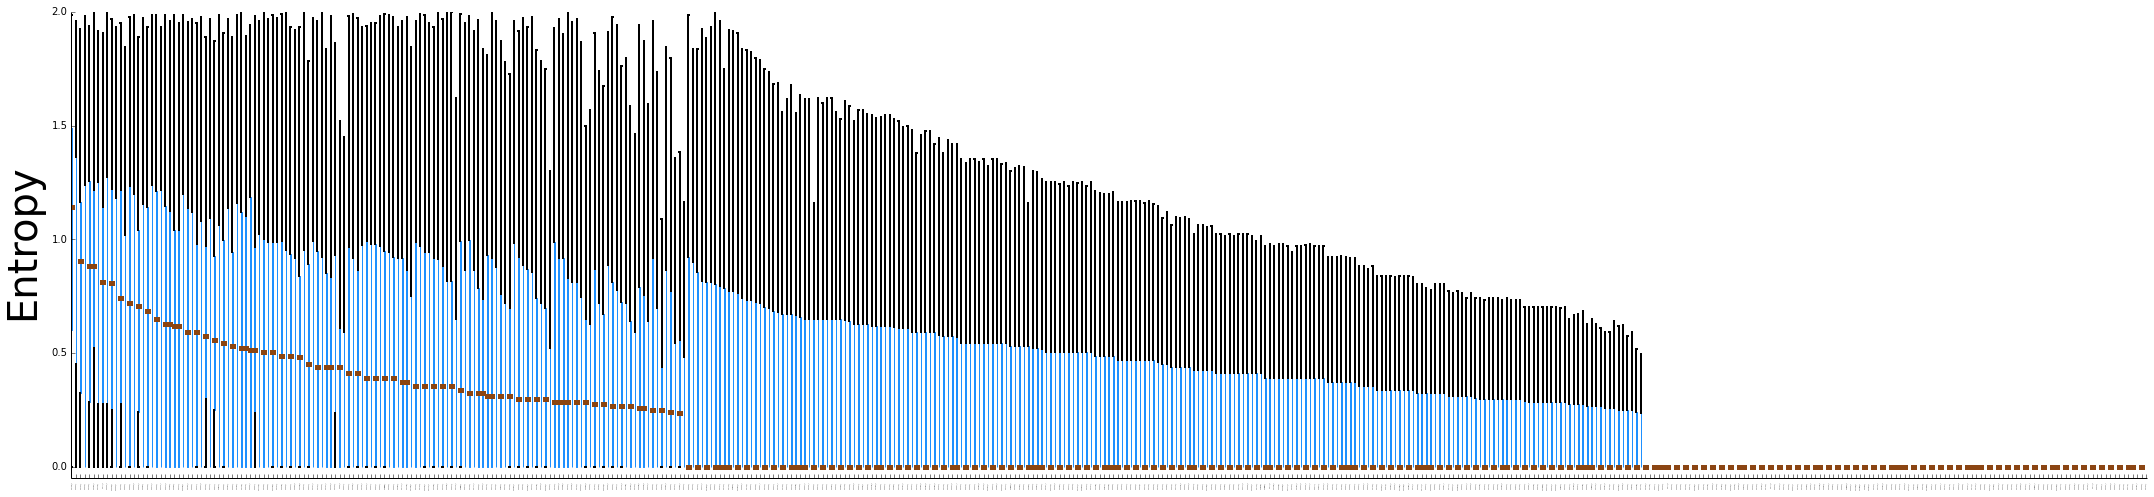

In [6]:
%matplotlib inline

stats.plot('entropy.png',     # Output file name
           
           figsize=(30,7),    # Figure size in cm
           
           params=['entropy'],# The parameters to include.
                              # can take a list of just one or a few parameters
                              # including 'entropy','conservation', 'gapscore'
                              # 'sequence_length' and 'sequence_gc'
           
           lable_fsize=40,
           
           xtick_fsize=0,
           
           ytick_fsize=1,
          
           boxcolor='DodgerBlue',
           whiskercolor='black',
           capcolor='black',
           mediancolor='SaddleBrown',
           medianline_w=5)

### 2.6.4 Figure S1, Plot a box plot for each parameter for each locus
In the resulting figure the loci will be sorted in a descending order of the entropy median, as a result of the above sorting step.
As expected, entropy is correlated with the conservation value. It is not correlated with other measures which makes its effect easy to check.

In [5]:
stats.plot('plot.png',     # Output file name
           
           figsize=(50,23), # Figure size in cm
           
           params='all',    # The parameters to include.
                            # can take a list of just one
                            # or a few parameters
                            # including 'entropy','conservation',
                            # 'gapscore', 'sequence_length'
                            # and 'sequence_gc'
           
           lable_fsize=20,
           
           xtick_fsize=10,
           
           ytick_fsize=1,
          
           boxcolor='salmon',
           whiskercolor='gray',
           capcolor='black',
           mediancolor='white',
           medianline_w=3)

## 2.7 Prepare the Concatenation objects
`Concatenation` objects contain the configuration information for building a supermatrix. This will produce six `Concatenation` objects each with a sliding window of 200 loci, along the entropy gradient.

In [21]:
concatenations = stats.slide_loci('source_original_id', # OTU metadata value.
                                                        # sequences from different loci
                                                        # ,which share this value,
                                                        # will be considered to belong to
                                                        # the same sample and will be
                                                        # concatenated
                                  
                                  median_range='all',   # Before starting the slide,
                                                        # you can exclude loci
                                  parameter='entropy',  # which median fall outside
                                                        # the specified range
                                                        # of the specified parameter.
                                                        # The remaining loci will still
                                                        # be sorted according to the
                                                        # parameter specified in the
                                                        # sorting step above, and not
                                                        # according to the parameter that
                                                        # specified here, if it is
                                                        # different from above.
                                  
                                  start=0,              # Counting from the first locus
                                                        # that was not excluded,
                                                        # start the first window here.
                                  
                                  length=200,           # the length of the window,
                                                        # counting 200 loci that were
                                                        # not filtered out
                                  
                                  step=50)              # the length of the slide.

# Add the concatenation objects to the project
for concat in concatenations:
    pj.add_concatenation(concat)
    
# Create the supermatrices
pj.make_concatenation_alignments()

# And collect their names
aln_names = [c.name for c in pj.concatenations]

entropy_1.14_0.00_loci_0_to_199
entropy_0.48_0.00_loci_50_to_249
entropy_0.30_0.00_loci_100_to_299
entropy_0.00_0.00_loci_150_to_349
entropy_0.00_0.00_loci_200_to_399
entropy_0.00_0.00_loci_250_to_449
Concatenation entropy_1.14_0.00_loci_0_to_199 will have the following data
OTU                           EOG6M65NR_1         EOG6SN1SH_1         EOG654933_1         EOG66147B_1         EOG680J15_1         EOG6S7JTK_1         EOG60ZR1Z_1         EOG6DBTJG_1         EOG69ZXTF_1         EOG64QT4T_1         EOG6K3M19_1         EOG60P4BJ_1         EOG6DBTK0_1         EOG64MXX7_1         EOG6GTKHJ_1         EOG6NVZQC_1         EOG6MPHV2_1         EOG68KRFS_1         EOG6GHZSR_1         EOG666VQ4_1         EOG651DV5_1         EOG6JDHBD_1         EOG63212K_1         EOG68D102_1         EOG6CJVMH_1         EOG60VVTB_1         EOG698V46_1         EOG6N8R81_1         EOG6FXRCK_1         EOG6R2400_1         EOG68KRG4_1         EOG61C70T_1         EOG6SJ5JS_1         EOG63212W_1         EOG6F7NPJ_1   

## 2.8 Reconstruct the trees
This will build trees only for the supermatrices because we pass their names. First we configure the analysis using a `RaxmlConf` object and then we execute it.  
The `RaxmlConf` object has several presets coresponding to several tree reconstruction approaches. These can be modified by using command line arguments. Alternatively, the program Phylobayes can be used with the `PbConf` object.

In [ ]:
raxml = RaxmlConf(pj,
                  
                  method_name='fa',
                  
                  program_name='raxmlHPC-PTHREADS-SSE3',
                  
                  keepfiles=False,                           # RAxML result files are
                                                             # deleted by default
                  
                  
                  cmd='default',
                  
                  preset='fa',                               # The default preset 'fa',
                                                             # will invoke the " -f a "
                                                             # algorithm. See manual for
                                                             # other presets
                  
                  alns=aln_names,                            # Instead of the default value
                                                             # 'all', this object will apply
                                                             # only for the supermatrices
                                                             
                  model='GAMMA',                             # Any RAxML model
                  
                  matrix='JTT',                              # Any substitution matrix in RAxML.
                                                             # For DNA data, this defaults to GTR
                  
                  
                  cline_args={},                             # Any RAxML keyword and argument.
                                                             # For example: {'#': 1000}, will change
                                                             # the default 100 rappid bootstrap
                                                             # replicates.
                  
                  threads=6)

# reconstruct the trees
pj.tree([raxml])

raxmlHPC-PTHREADS-SSE3 -f a -m PROTGAMMAJTT -n 357421429738848.49_entropy_0.48_0.00_loci_50_to_2490 -q 357421429738848.49_entropy_0.48_0.00_loci_50_to_249_partfile -p 122 -s 357421429738848.49_entropy_0.48_0.00_loci_50_to_249.fasta -T 6 -x 388 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m PROTGAMMAJTT -n 357421429738848.49_entropy_0.00_0.00_loci_200_to_3990 -q 357421429738848.49_entropy_0.00_0.00_loci_200_to_399_partfile -p 607 -s 357421429738848.49_entropy_0.00_0.00_loci_200_to_399.fasta -T 6 -x 442 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m PROTGAMMAJTT -n 357421429738848.49_entropy_0.30_0.00_loci_100_to_2990 -q 357421429738848.49_entropy_0.30_0.00_loci_100_to_299_partfile -p 446 -s 357421429738848.49_entropy_0.30_0.00_loci_100_to_299.fasta -T 6 -x 186 -N 100
raxmlHPC-PTHREADS-SSE3 -f a -m PROTGAMMAJTT -n 357421429738848.49_entropy_1.14_0.00_loci_0_to_1990 -q 357421429738848.49_entropy_1.14_0.00_loci_0_to_199_partfile -p 748 -s 357421429738848.49_entropy_1.14_0.00_loci_0_to_199.fasta -T 6 -x 235 

#### Note:
The value of -m is always PROT for concatenations. This is overridden by the partition file, where DNA will be specified for DNA partitions, envoking the GTR matrix of nucleic acid substitution. You can check the info file while the analysis runs or by using the `keepfiles = True` keyword to verify.

## 2.9 Verify git commit
At any step it is possible to confirm that git is working and recording the changes

In [24]:
print pj.last_git_log()


Sun Apr 26 08:44:54 2015
STDOUT:
[master 6c085d7] RaxmlConf named fa with ID 357421429738848.49 Alignments: entropy_0.48_0.00_loci_50_to_249,entropy_0.00_0.00_loci_200_to_399,entropy_0.30_0.00_loci_100_to_299,entropy_1.14_0.00_loci_0_to_199,entropy_0.00_0.00_loci_150_to_349,entropy_0.00_0.00_loci_250_to_449 Created on: Wed Apr 22 22:40:48 2015 Commands: entropy_0.48_0.00_loci_50_to_249: [RaxmlCommandline(cmd='raxmlHPC-PTHREADS-SSE3', algorithm='a', model='PROTGAMMAJTT', name='357421429738848.49_entropy_0.48_0.00_loci_50_to_2490', partition_filename='357421429738848.49_entropy_0.48_0.00_loci_50_to_249_partfile', parsimony_seed=122, sequences='357421429738848.49_entropy_0.48_0.00_loci_50_to_249.fasta', threads=6, rapid_bootstrap_seed=388, num_replicates=100)] entropy_0.00_0.00_loci_200_to_399: [RaxmlCommandline(cmd='raxmlHPC-PTHREADS-SSE3', algorithm='a', model='PROTGAMMAJTT', name='357421429738848.49_entropy_0.00_0.00_loci_200_to_3990', partition_filename='357421429738848.49_entropy_0.

## 2.10 Plot the trees - Figure 2A 1-6

In [28]:
# Remove stars from species names  
from itertools import chain

for f in chain(*[r.features for r in pj.records]):
    if 'Taxa' in f.qualifiers:
        f.qualifiers['Taxa'][0] = f.qualifiers['Taxa'][0].replace('*','')
        
pj.propagate_metadata()

pics = {'Bombycoidea': 'silhouettes/Bombycoidea.png',
        'Calliduloidea': 'silhouettes/Calliduloidea.png',
        'Cossoidea': 'silhouettes/Cossoidea.png',
        'Gelechioidea': 'silhouettes/Gelechioidea.png',
        'Geometroidea': 'silhouettes/Geometroidea.png',
        'Hepialoidea': 'silhouettes/Hepialoidea.png',
        'Papilionoidea': 'silhouettes/Papilionoidea.png',
        'Mimallonoidea': 'silhouettes/Mimallonoidea.png',
        'Zygaenoidea': 'silhouettes/Zygaenoidea.png',
        'Lasiocampoidea': 'silhouettes/Lasiocampoidea.png',
        'Thyridoidea': 'silhouettes/Thyridoidea.png',
        'Pterophoroidea': 'silhouettes/Pterophoroidea.png',
        'Pyraloidea': 'silhouettes/Pyraloidea.png',
        'Noctuoidea': 'silhouettes/Noctuoidea.png',
        'Gracillarioidea': 'silhouettes/Gracillarioidea.png',
        'Yponomeutoidea': 'silhouettes/Yponomeutoidea.png',
        'Urodoidea': 'silhouettes/Urodoidea.png',
        'Tortricoidea': 'silhouettes/Tortricoidea.png'
        
       }

colors = {'Bombycoidea': 'DodgerBlue',
          'Calliduloidea': 'DodgerBlue',
          'Cossoidea': 'DodgerBlue',
          'Gelechioidea': 'DodgerBlue',
          'Geometroidea': 'DodgerBlue',
          'Hepialoidea': 'DodgerBlue',
          'Papilionoidea': 'SaddleBrown',
          'Mimallonoidea': 'DodgerBlue',
          'Zygaenoidea': 'DodgerBlue',
          'Lasiocampoidea': 'DodgerBlue',
          'Thyridoidea': 'DodgerBlue',
          'Pterophoroidea': 'DodgerBlue',
          'Pyraloidea': 'DodgerBlue',
          'Noctuoidea': 'DodgerBlue',
         'Gracillarioidea': 'DodgerBlue',
         'Yponomeutoidea': 'DodgerBlue',
         'Urodoidea': 'DodgerBlue',
         'Tortricoidea': 'DodgerBlue'}
            
bg =  {'butterfilies': 'LightSkyBlue',
       'I': 'PowderBlue',
       'III': 'LightGrey',
       'IV': 'Beige'
      }


supports = { 'DarkBlue' : [100,99],
             'DimGray': [99,80]}
             #'PaleTurquoise': [80,50]}


dir_name = "butterfly_figs"

html_name = "%s/figures.html"%dir_name

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

pj.clear_tree_annotations()  

pj.annotate(dir_name,                    # Where to save the figures
            
            'mid',                       # Root at midpoint. Alternatively, specify
            'mid',                       # metadata and value to define outgroup
            
            ['Taxa'],             # a list of metadata fields to use for labels
            leaf_node_color_meta='source_Superfamily',
            leaf_label_colors=colors,
            ftype='Arial Black',
            fsize=40,
            
            node_support_dict=supports,  # colors and ranges of node support annotations
            support_bullet_size=15,
            
            pic_meta='source_Superfamily', 
            pic_paths=pics,
            pic_w=85, pic_h=65,
            
            node_bg_meta='Clade',     
            node_bg_color=bg,
            
            branch_width=6, branch_color='RoyalBlue',
            
            scale=2500,
            
            html=html_name)

In [1]:
from reprophylo import *
pj = unpickle_pj('szitenberg_et_al_15_reprophylo')

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened
/home/amir/Dropbox/python_modules/reprophylo.py:240: UserWarning: Git repository exists for this Project
  warnings.warn('Git repository exists for this Project')


## 2.11 Robinson-foulds like metrics

In [4]:
# Sort the trees in sensible order (optional)
pj.trees.keys()

['entropy_0.00_0.00_loci_250_to_449@mixed@mixed@fa',
 'entropy_0.30_0.00_loci_100_to_299@mixed@mixed@fa',
 'entropy_1.14_0.00_loci_0_to_199@mixed@mixed@fa',
 'entropy_0.48_0.00_loci_50_to_249@mixed@mixed@fa',
 'entropy_0.00_0.00_loci_200_to_399@mixed@mixed@fa',
 'entropy_0.00_0.00_loci_150_to_349@mixed@mixed@fa']

In [3]:
trees = ['entropy_1.14_0.00_loci_0_to_199@mixed@mixed@fa',
         'entropy_0.48_0.00_loci_50_to_249@mixed@mixed@fa',
         'entropy_0.30_0.00_loci_100_to_299@mixed@mixed@fa',
         'entropy_0.00_0.00_loci_150_to_349@mixed@mixed@fa',
         'entropy_0.00_0.00_loci_200_to_399@mixed@mixed@fa',
         'entropy_0.00_0.00_loci_250_to_449@mixed@mixed@fa',
        ]

### 2.11.1 Figure 2B: Topological

In [9]:
if not os.path.exists('rf_figs'):
    os.mkdir('rf_figs')
    
# topological

figfile1, legend = calc_rf(pj, 'rf_figs', rf_type='topology', unrooted_trees=True, trees=trees)

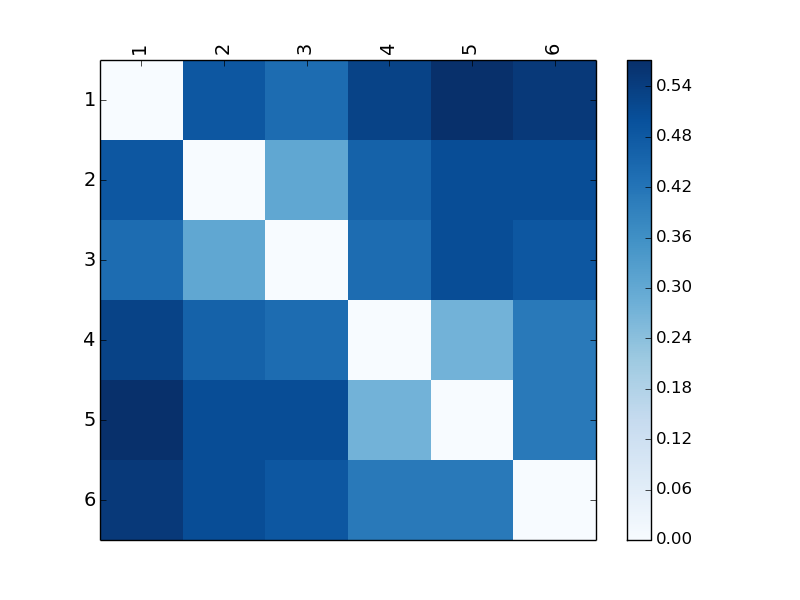

In [10]:
import IPython.display
IPython.display.Image(figfile1)

In [11]:
print figfile1

rf_figs/1387.png


In [12]:
IPython.display.HTML(data=(HTML.table(legend[1:], header_row=legend[0])))

#### Say we need to recall what Tree Metdod `fa` is:

In [13]:
print pj.used_methods['fa']

RaxmlConf named fa with ID 357421429738848.49
Alignments: entropy_0.48_0.00_loci_50_to_249,entropy_0.00_0.00_loci_200_to_399,entropy_0.30_0.00_loci_100_to_299,entropy_1.14_0.00_loci_0_to_199,entropy_0.00_0.00_loci_150_to_349,entropy_0.00_0.00_loci_250_to_449 
Created on: Wed Apr 22 22:40:48 2015
Commands:
entropy_0.48_0.00_loci_50_to_249: [RaxmlCommandline(cmd='raxmlHPC-PTHREADS-SSE3', algorithm='a', model='PROTGAMMAJTT', name='357421429738848.49_entropy_0.48_0.00_loci_50_to_2490', partition_filename='357421429738848.49_entropy_0.48_0.00_loci_50_to_249_partfile', parsimony_seed=122, sequences='357421429738848.49_entropy_0.48_0.00_loci_50_to_249.fasta', threads=6, rapid_bootstrap_seed=388, num_replicates=100)]
entropy_0.00_0.00_loci_200_to_399: [RaxmlCommandline(cmd='raxmlHPC-PTHREADS-SSE3', algorithm='a', model='PROTGAMMAJTT', name='357421429738848.49_entropy_0.00_0.00_loci_200_to_3990', partition_filename='357421429738848.49_entropy_0.00_0.00_loci_200_to_399_partfile', parsimony_seed=

### 2.11.2 Figure 2 C: Branch length

In [14]:
if not os.path.exists('rf_figs'):
    os.mkdir('rf_figs')
    
# branch-length

figfile2, legend = calc_rf(pj, 'rf_figs', rf_type='branch-length', unrooted_trees=True, trees=trees)

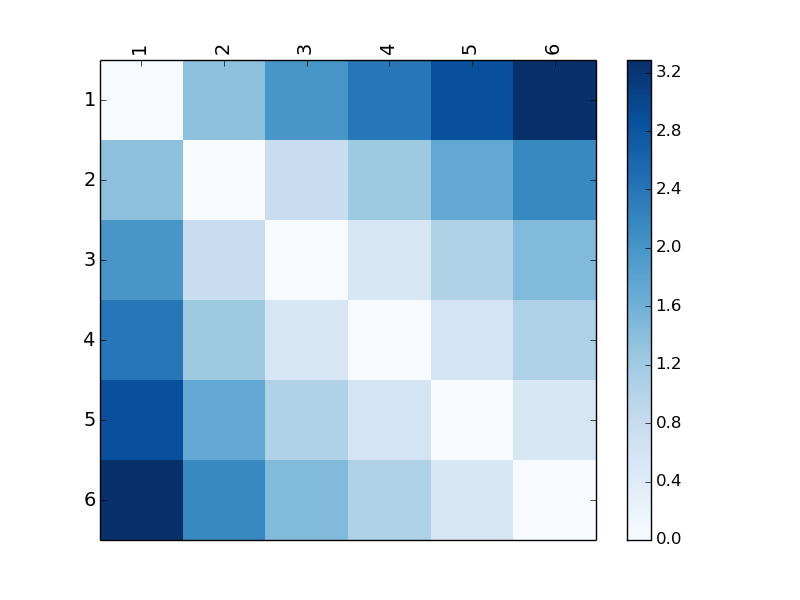

In [15]:
IPython.display.Image(figfile2)

In [16]:
print figfile2

rf_figs/1138.png


In [17]:
IPython.display.HTML(data=(HTML.table(legend[1:], header_row=legend[0])))

### 2.11.3 Figure 2 D: proportional

In [4]:
if not os.path.exists('rf_figs'):
    os.mkdir('rf_figs')
    
# topological
figfile3,legend = calc_rf(pj, 'rf_figs', rf_type='proportional', unrooted_trees=True, trees=trees)

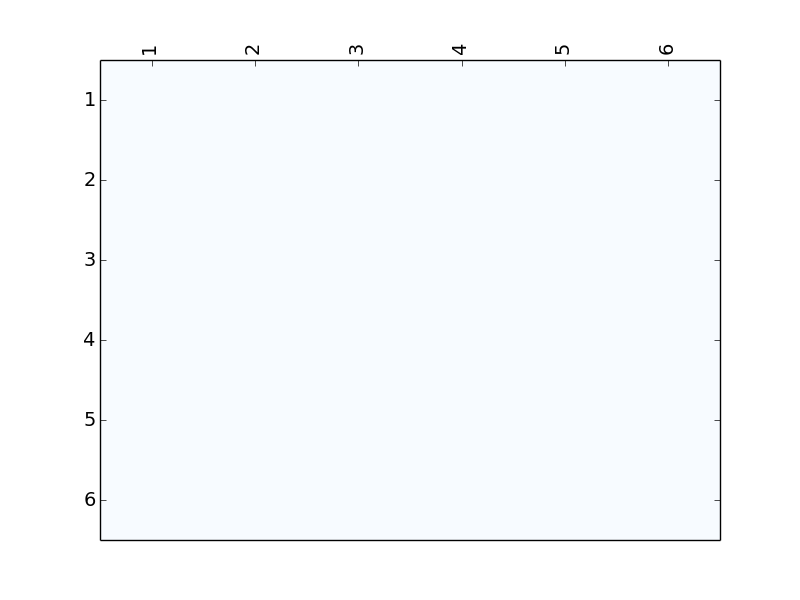

In [5]:
IPython.display.Image(figfile3)

In [20]:
print figfile3

rf_figs/1202.png


In [21]:
IPython.display.HTML(data=(HTML.table(legend[1:], header_row=legend[0])))

## 2.12 Prepare zip folder

In [5]:
publish(pj, 'report', 'butterfly_figs/',
        compare_trees=['topology','branch-length','proportional'],
        trees_to_compare=trees, unrooted_trees=True )

checking if file exists
reporter was called by publish
starting species table
starting concatenations
starting methods
starting alignment statistics
starting RF matrix(ces)
reporting trees
pickling
archiving
report ready


## 2.13 Add README and commit

In [9]:
%%file README.md
This repository was automatically created and 
maintained by [ReproPhylo V1](http://hulluni-bioinformatics.github.io/ReproPhylo/). 
It contains the analysis done for the paper *ReproPhylo: a python package 
 for reproducible phylogenomics* by Amir Szitenberg, Max John, Mark Blaxter and David Lunt.


Writing README.md


## 2.14 Manual commit of some additional files

In [7]:
# Just in case, commit the pickle again
pickle_pj(pj, "szitenberg_et_al_15_reprophylo")

'szitenberg_et_al_15_reprophylo'

In [10]:
# files to add manually:
files=['rf_figs', 'butterfly_figs/', 'silhouettes/', 'MethodsS1.html, Figure1.pdf', 'Figure1.png',
      'Figure2.pdf', 'Figure2.png', 'Figure2.png', 'plots.png', 'entropy.png',
      'README.md']

for f in files:
    rpgit.gitAdd(f)
rpgit.gitCommit('Additional files for the MS commited manually')

('[master da6bc03] Additional files for the MS commited manually\n 1 file changed, 4 insertions(+)\n create mode 100644 README.md\n',
 '')